# PA003: Churn Predict

# 0.0 Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import math
import pickle
import inflection

from IPython.core.display          import HTML
from scipy.stats import shapiro, chi2_contingency

from sklearn                       import preprocessing            as pp
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from BorutaShap import BorutaShap

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline        import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report
from catboost import CatBoostClassifier, metrics, Pool
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix, ClassificationReport, ROCAUC, ClassPredictionError, DiscriminationThreshold


from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek 


# from sklearn.preprocessing import StandardScaler, MinMaxScaler , RobustScaler


import warnings
warnings.filterwarnings("ignore")

## 0.1.Helper function

In [2]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.3f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [3]:
 def numerical_descriptive_statistical(num_attributes):
        
    """
    Shows the main values  for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): Insert all numerical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range
    """
            
    # Central Tendency - Mean, Median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis, Shapiro-Wilk Test
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    return m



def categorical_descriptive_statstical(data , col):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([object]): Insert all categorical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with absolute and percent values
    """
    return pd.DataFrame({'absolute' : data[col].value_counts() , 'percent %': data[col].value_counts(normalize = True) * 100})

In [4]:
def correlation_matrix(data , method):
    """Generates a correlation matrix of numerical variables

    Args:correlation_matrix
        data ([DataFrame]): [The dataframe of the EDA]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes( include = ['int64' , 'float64'])
    correlation = num_attributes.corr( method = method)
#     correlation.append('exited')
    
#     df_corr = data[correlation].reset_index(drop=True)
#     df_corr['exited'] = df_corr['exited'].astype('int')
    
    # mask
    mask = np.zeros_like(correlation)
    mask = np.triu(np.ones_like(correlation , dtype = np.bool))
    
    # plot -  mask = mask ,
    ax = sns.heatmap(correlation , fmt = '.2f' , vmin = -1 , vmax = 1, annot =  True, cmap = 'YlGnBu' , square = True)
    
    return ax

In [5]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)

def plot_cat_overview(df, cat_attributes, target):
    
    cat_attributes.remove(target)

    plots_lin = math.ceil(len(cat_attributes)/2)

    fig, axs = plt.subplots(plots_lin,2, figsize=(25, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.20)
    axs = axs.ravel()    

    for c in range(len(cat_attributes)):
        ax1 = sns.countplot(ax=axs[c], x=cat_attributes[c],hue=target, data=df)
        without_hue(ax1,df1.exited)

In [6]:
def sum_of_na (data):
    return pd.DataFrame({'Sum of NA' : data.isna().sum(), '% NA': data.isna().sum()/data.shape[0]})

In [7]:
def lift_score(y, y_pred, **kwargs):    
    df = pd.DataFrame()
    df['true'] = y
    df['pred'] = y_pred
    df.sort_values('pred', ascending=False, inplace=True)
    N = len(df)
    churn_total = df['true'].sum() / N
    n = int(np.ceil(.1 * N)) 
    data_here = df.iloc[:n, :]
    churn_here = data_here['true'].sum() / n
    lift = churn_here / churn_total
    return lift

In [8]:
 def knapsack(W, wt, val):
    n = len(val)
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    max_val = K[n][W]
    keep = [False] * n
    res = max_val
    w = W
    for i in range(n, 0, -1):
        if res <= 0: break
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
    del K
    return max_val, keep

## 0.2. Loading Data

In [9]:
df_raw = pd.read_csv(r'~/repositorio/churn_predict/data/raw/churn.csv')

In [10]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


# 1.0. Data Description


 - **RowNumber**      : O número da coluna.
 - **CustomerID**     : Identificador único do cliente.
 - **Surname**        : Sobrenome do cliente.
 - **CreditScore**    : A pontuação de Crédito do cliente para o mercado de consumo.
 - **Geography**      : O país onde o cliente reside.
 - **Gender**         : O gênero do cliente.
 - **Age**            : A idade do cliente.
 - **Tenure**         : Número de anos que o cliente permaneceu ativo.
 - **Balance**        : Valor monetário que o cliente tem em sua conta bancária.
 - **NumOfProducts**  : O número de produtos comprado pelo cliente no banco.
 - **HasCrCard**      : Indica se o cliente possui ou não cartão de crédito.
 - **IsActiveMember** : Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
 - **EstimateSalary** : Estimativa do salário mensal do cliente.
 - **Exited**         : Indica se o cliente está ou não em Churn.

In [11]:
df1 = df_raw.copy()

In [12]:
df1.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [13]:
df1.duplicated('CustomerId').sum() 

0

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 1.1 Rename Columns

In [15]:
old_columns=list(df1.columns)

snakecase = lambda x : inflection.underscore(x)
new_columns = map(snakecase , old_columns)

# rename columns
df1.columns = new_columns


## 1.2. Data Dimensions

In [16]:
print('Numbers of rows: {}'.format(df1.shape[0]))
print('Numbers of cols: {}'.format(df1.shape[1]))

Numbers of rows: 10000
Numbers of cols: 14


## 1.3. Data Types

In [17]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [18]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

### 1.3.1. Change Data Types

In [19]:
df1.exited = df1.exited.astype('bool')
df1.has_cr_card = df1.has_cr_card.astype('bool')
df1.is_active_member= df1.is_active_member.astype('bool')

### 1.3.2. Check unique values

In [20]:
df1.nunique()

row_number          10000
customer_id         10000
surname              2932
credit_score          460
geography               3
gender                  2
age                    70
tenure                 11
balance              6382
num_of_products         4
has_cr_card             2
is_active_member        2
estimated_salary     9999
exited                  2
dtype: int64

### 1.3.3. Remove Variables

In [21]:
cols_drop = ['row_number', 'surname', 'customer_id']
df1 = df1.drop(cols_drop , axis = 1)

## 1.4. Check NA

In [22]:
df1.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Data Descriptive

In [23]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1. Numerical Attributes


In [24]:
m = numerical_descriptive_statistical(num_attributes)
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,shapiro
0,credit_score,350.0,850.0,500.0,650.529,652.0,96.648,-0.072,-0.426,not normal
1,age,18.0,92.0,74.0,38.922,37.0,10.487,1.011,1.395,not normal
2,tenure,0.0,10.0,10.0,5.013,5.0,2.892,0.011,-1.165,not normal
3,balance,0.0,250898.09,250898.09,76485.889,97198.54,62394.285,-0.141,-1.489,not normal
4,num_of_products,1.0,4.0,3.0,1.53,1.0,0.582,0.746,0.583,not normal
5,estimated_salary,11.58,199992.48,199980.9,100090.24,100193.915,57507.617,0.002,-1.182,not normal


### 1.5.2. Categorical Attributes


In [25]:
cat_attributes.columns

Index(['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited'], dtype='object')

In [26]:
x = df1[['geography' , 'exited']].groupby('geography').count().reset_index()
x

,geography,exited
0,France,5014
1,Germany,2509
2,Spain,2477


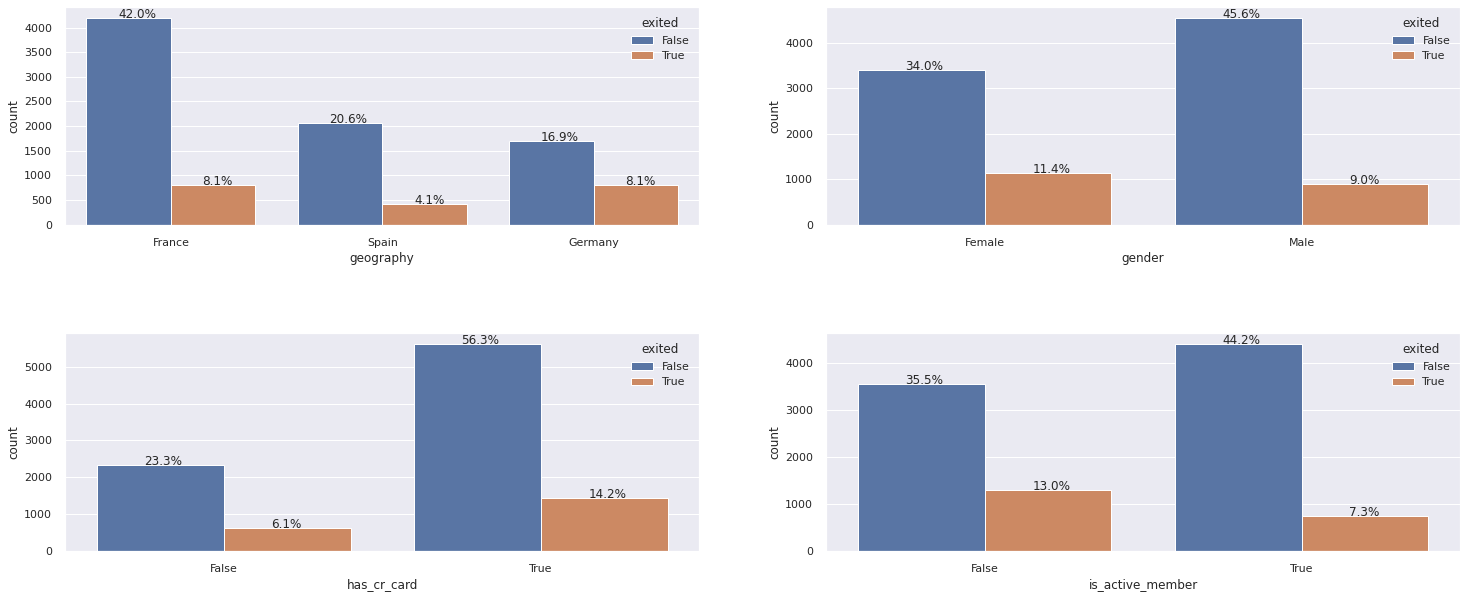

In [27]:
plot_cat_overview(cat_attributes, list(cat_attributes.columns), 'exited') 

In [28]:
categorical_descriptive_statstical(cat_attributes , 'geography')

,absolute,percent %
France,5014,50.140
Germany,2509,25.090
Spain,2477,24.770


In [29]:
categorical_descriptive_statstical(cat_attributes , 'gender')

,absolute,percent %
Male,5457,54.570
Female,4543,45.430


In [30]:
categorical_descriptive_statstical(cat_attributes , 'has_cr_card')

,absolute,percent %
True,7055,70.550
False,2945,29.450


In [31]:
categorical_descriptive_statstical(cat_attributes , 'is_active_member')

,absolute,percent %
True,5151,51.510
False,4849,48.490


In [32]:
categorical_descriptive_statstical(cat_attributes , 'exited')

,absolute,percent %
False,7963,79.630
True,2037,20.370


### 1.5.3. Multivariate Analysis



<AxesSubplot:>

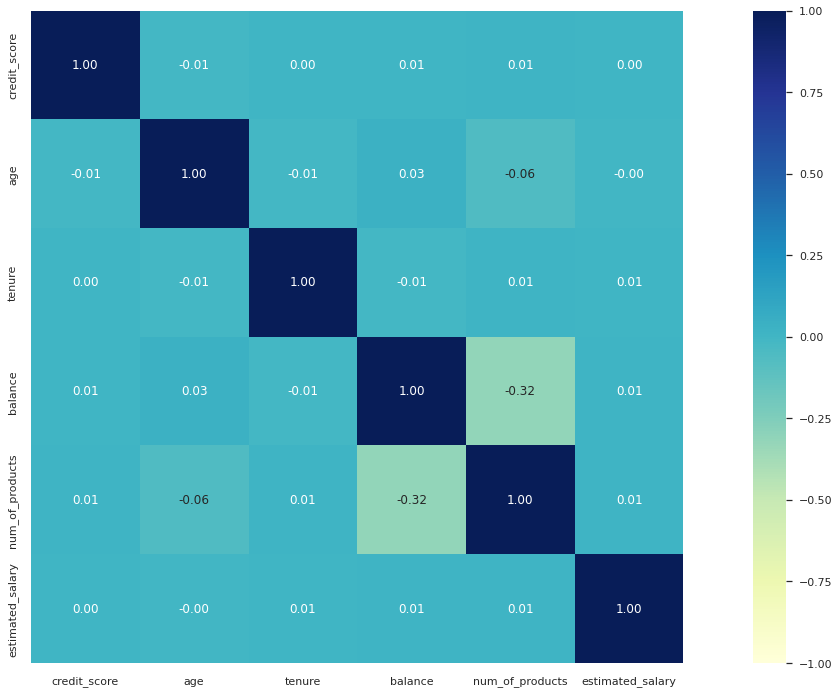

In [33]:
correlation_matrix(df1 , 'spearman')

### 1.5.4. Outliers Numerical Attributes


In [34]:
num_cols = num_attributes.columns.tolist()

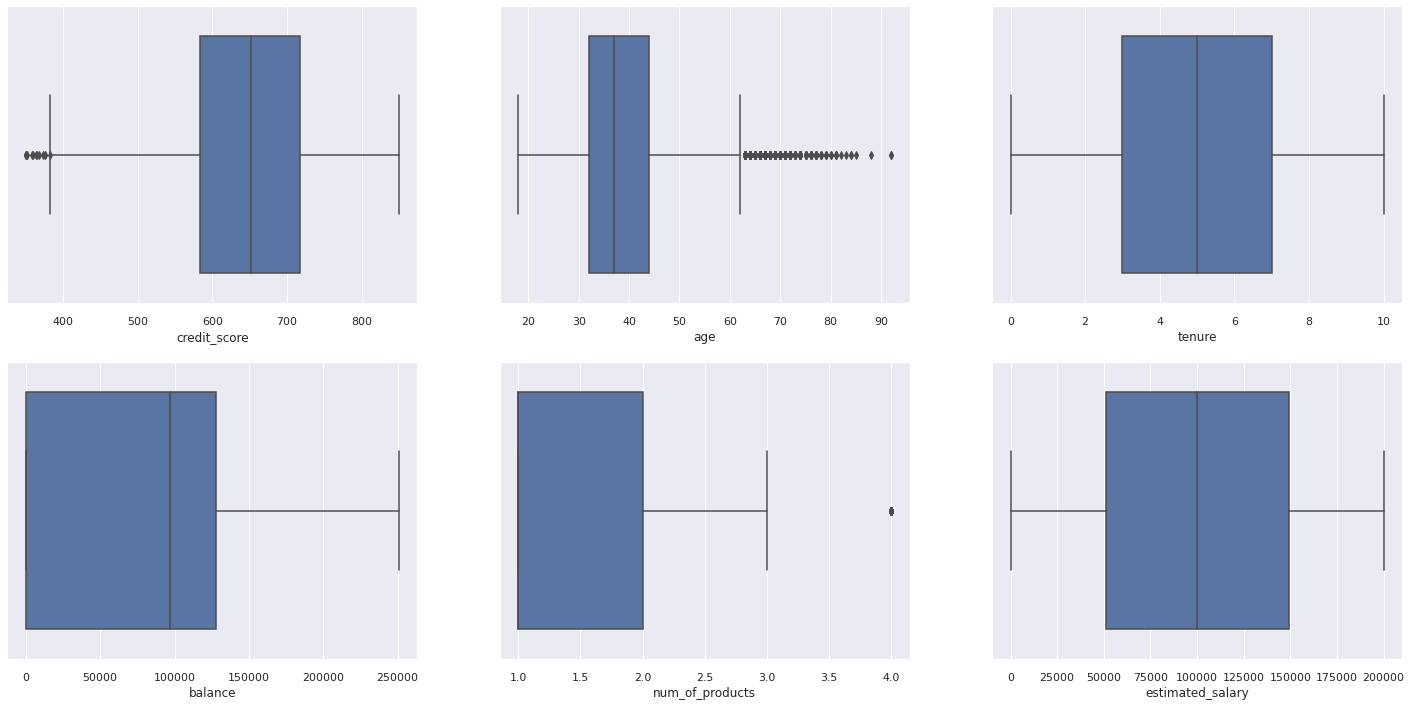

In [35]:
i = 1
for col in df1[num_cols]:
    plt.subplot(2,3,i)
    ax = sns.boxplot( data = df1 , x = col)
    i += 1
    

 **Important informations:**
 
- There are outliers in **credit_score, num_of_products and age**
- The **churn ratio is 20.37%**
- **70.6%** of the members **has credit card**
- More than **50% of the clients** are **from France**

# 2.0. Feature Engineering


In [36]:
df2 = df1.copy()

In [37]:
df2.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.000,1,True,True,101348.880,True
1,608,Spain,Female,41,1,83807.860,1,False,True,112542.580,False
2,502,France,Female,42,8,159660.800,3,True,False,113931.570,True
3,699,France,Female,39,1,0.000,2,False,False,93826.630,False
4,850,Spain,Female,43,2,125510.820,1,True,True,79084.100,False


## 2.1. Balance_age

In [38]:
# balance_per_age
balance_age = df2[['balance', 'age']].groupby('age').mean().reset_index()
balance_age.columns = ['age' , 'balance_age']

# merge

df2 = pd.merge(df2, balance_age, on = 'age' ,  how = 'left')

## 2.2. Balance_country


In [39]:
balance_country = df2.loc[:, ['geography', 'balance']].groupby('geography').mean().reset_index()
balance_country.columns = ['geography', 'balance_per_country']

# merge
df2 = pd.merge(df2, balance_country, on = 'geography', how = 'left')

## 2.3. Balance_tenure


In [40]:
balance_tenure = df2.loc[:, ['tenure', 'balance']].groupby('tenure').mean().reset_index()
balance_tenure.columns = ['tenure', 'LTV']

# merge
df2 = pd.merge(df2, balance_tenure, on = 'tenure', how = 'left')

## 2.3. Salary_gender


In [41]:
estimated_salary_gender = df2.loc[:, ['gender', 'estimated_salary']].groupby('gender').mean().reset_index()
estimated_salary_gender.columns = ['gender', 'estimated_salary_per_gender']

# merge
df2 = pd.merge(df2, estimated_salary_gender, on = 'gender', how = 'left')

<AxesSubplot:>

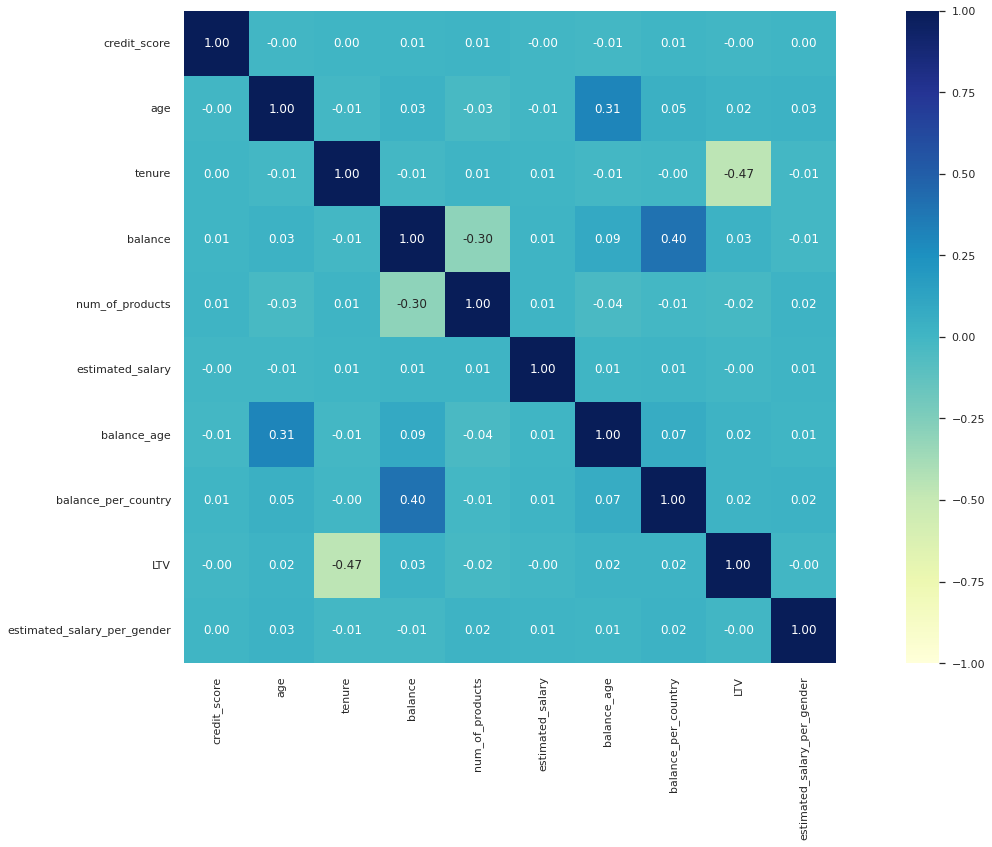

In [42]:
correlation_matrix(df2, 'pearson')

# 3.0. Data Filtering


In [43]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis (EDA)


In [44]:
df4 = df3.copy()

# 5.0. Data Preparation


In [45]:
df5 = df4.copy()

In [46]:
df5.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'balance_age', 'balance_per_country',
       'LTV', 'estimated_salary_per_gender'],
      dtype='object')

In [47]:
df5.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,balance_age,balance_per_country,LTV,estimated_salary_per_gender
0,619,France,Female,42,2,0.000,1,True,True,101348.880,True,76785.312,62092.637,76839.626,100601.541
1,608,Spain,Female,41,1,83807.860,1,False,True,112542.580,False,75742.975,61818.148,78555.384,100601.541
2,502,France,Female,42,8,159660.800,3,True,False,113931.570,True,76785.312,62092.637,77936.598,100601.541
3,699,France,Female,39,1,0.000,2,False,False,93826.630,False,74285.289,62092.637,78555.384,100601.541
4,850,Spain,Female,43,2,125510.820,1,True,True,79084.100,False,81636.038,61818.148,76839.626,100601.541


In [48]:

df5.exited = df1.exited.astype('int64')
df5.has_cr_card = df1.has_cr_card.astype('int64')
df5.is_active_member= df1.is_active_member.astype('int64')

## 5.1. Rescaling

In [49]:
mms = pp.MinMaxScaler()
rbs = pp.RobustScaler()

cols_rob =['age']
cols_mms = ['credit_score', 'tenure', 'salary']


df5['age'] = rbs.fit_transform(df5[['age']].values)

#Balance
df5['balance'] = mms.fit_transform(df5[['balance']].values)
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)


df5['balance_age'] = mms.fit_transform(df5[['balance_age']].values)
df5['balance_per_country'] = mms.fit_transform(df5[['balance_per_country']].values)
df5['LTV'] = mms.fit_transform(df5[['LTV']].values)
df5['estimated_salary_per_gender'] = mms.fit_transform(df5[['estimated_salary_per_gender']].values)


#EstimatedSalary
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)

#LTV
df5['LTV'] = mms.fit_transform(df5[['LTV']].values)




## 5.2. Encoding

In [50]:
# #gender - label encoding 
# gender_dict = { 'Male':0 , 'Female':1 }
# df5['gender'] = df5['gender'].map( gender_dict ) 

# #Geography - One Hot Encoding
# # one hot encoding encoding 
df5 = pd.get_dummies(df5, prefix=['country'], columns=['geography'])
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender'])

# questions_encoding = {'False': 0,'True': 1}

# df5['is_active_member'] = df5['is_active_member'].map(questions_encoding )
# df5['has_cr_card'] = df5['has_cr_card'].map(questions_encoding)
# df5['exited'] = df5['exited'].map(questions_encoding)

## 5.3. Balanicing Data Set

In [51]:
x = df5.drop('exited', axis = 1)
y = df5.exited

x_train, x_test,y_train, y_test = train_test_split(x , y , test_size=0.33 , random_state = 42, stratify = y)

In [52]:
# balance dataset
up_sampler = SMOTETomek(random_state=42 , n_jobs = -1)

x_train_res , y_train_res = up_sampler.fit_resample(x_train , y_train)

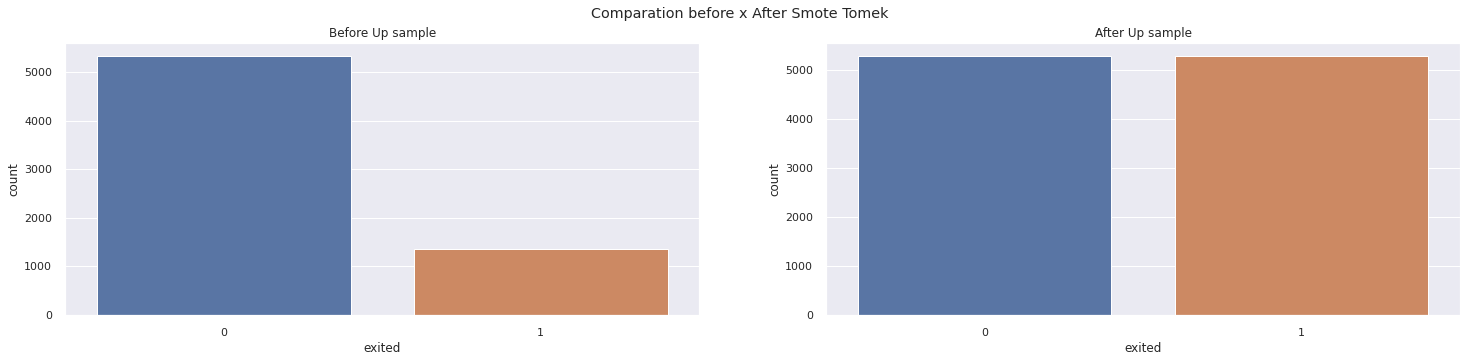

In [53]:
fig , axes = plt.subplots(1,2, figsize = (25,5))

fig.suptitle('Comparation before x After Smote Tomek')

axes[0].set_title('Before Up sample')
ax1 = sns.countplot(ax = axes[0] , x=y_train)

axes[1].set_title('After Up sample')
ax1 = sns.countplot(ax = axes[1] , x=y_train_res)

# 6.0. Feature Selection


In [54]:
df6 = df5.copy()

In [55]:
df6.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,balance_age,balance_per_country,LTV,estimated_salary_per_gender,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,0.417,0.200,0.000,1,1,1,0.507,1,0.620,0.005,0.489,1.000,1,0,0,1,0
1,608,0.333,0.100,0.334,1,0,1,0.563,0,0.612,0.000,0.778,1.000,0,0,1,1,0
2,502,0.417,0.800,0.636,3,1,0,0.570,1,0.620,0.005,0.674,1.000,1,0,0,1,0
3,699,0.167,0.100,0.000,2,0,0,0.469,0,0.600,0.005,0.778,1.000,1,0,0,1,0
4,850,0.500,0.200,0.500,1,1,1,0.395,0,0.659,0.000,0.489,1.000,0,0,1,1,0


In [56]:
# no model selected default is Random Forest, we will use a CatBoostClassifier. If classification is True it is a Classification problem.

#cat_boruta = CatBoostClassifier(random_state=42)
# rf = RandomForestClassifier(n_jobs=-1 )


# Feature_Selector_rf = BorutaShap(model = rf,
#                               importance_measure='shap',
#                               classification=True)

# Feature_Selector_rf.fit(X=x_train_res, y=y_train_res, n_trials=100, verbose=True, train_or_test = 'train', random_state=42)

In [57]:
model = XGBClassifier(n_jobs=-1 )


Feature_Selector_rf = BorutaShap(model = model,
                              importance_measure='shap',
                              classification=True)

Feature_Selector_rf.fit(X=x_train_res, y=y_train_res, n_trials=100, verbose=True, train_or_test = 'train', random_state=42)

  0%|          | 0/100 [00:00<?, ?it/s]

[12:16:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[12:20:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[12:28:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:28:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:28:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:29:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[12:35:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
12 attributes confirmed important: ['credit_score', 'is_active_member', 'balance_per_country', 'estimated_salary', 'tenure', 'num_of_products', 'LTV', 'country_France', 'estimated_salary_per_gender', 'balance', 'age', 'balance_age']
5 attributes confirmed unimportant: ['gender_Female', 'country_Germany', 'country_Spain', 'gender_Male', 'has_cr_card']
0 tentative attributes remains: []


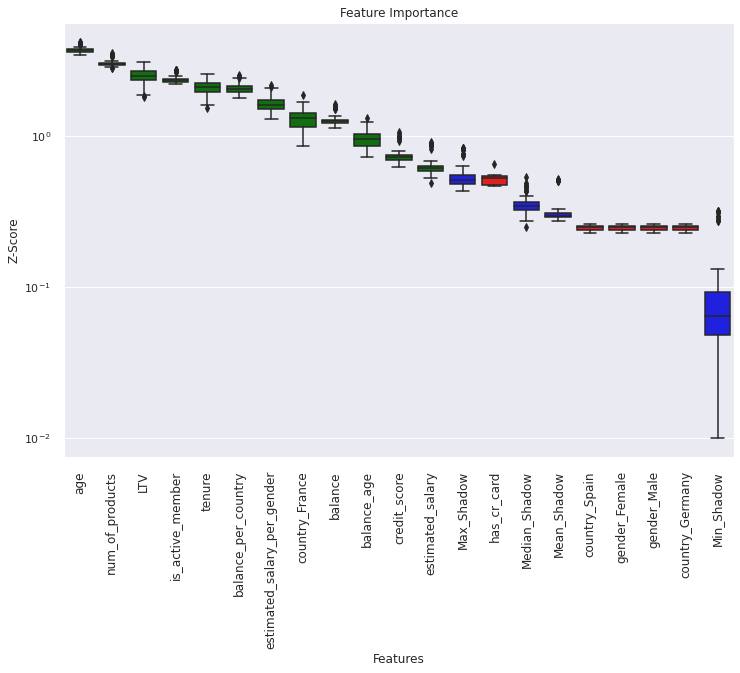

In [58]:
 # Returns Boxplot of features
Feature_Selector_rf.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='all')

In [59]:
subset = Feature_Selector_rf.Subset()
subset.head()

,credit_score,is_active_member,balance_per_country,estimated_salary,tenure,num_of_products,LTV,country_France,estimated_salary_per_gender,balance,age,balance_age
0,644,1,0.005,0.209,0.500,2,0.423,1,0.000,0.000,-0.500,0.610
1,600,1,0.005,0.510,0.100,1,0.778,1,0.000,0.000,-0.417,0.611
2,567,0,0.000,0.311,0.100,1,0.778,0,1.000,0.627,0.667,0.645
3,640,1,1.000,0.035,0.900,4,0.443,0,0.000,0.525,0.167,0.600
4,611,1,0.005,0.513,0.100,2,0.778,1,0.000,0.000,0.250,0.622


# 7.0. Machine Learning Modelling


In [60]:
df7 = df6.copy()

## 7.1. Logistic Regression

In [61]:
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                        class_weight=None, random_state=42, solver='lbfgs', max_iter=100, multi_class='auto',
                        verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None)
lr.fit(x_train_res, y_train_res)

LogisticRegression(n_jobs=-1, random_state=42)

## 7.2. Random Forest

In [62]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            bootstrap=True, oob_score=False, n_jobs=-1,
                            random_state=42, verbose=0, warm_start=False, class_weight=None,
                            ccp_alpha=0.0, max_samples=None)
rf.fit(x_train_res, y_train_res)

RandomForestClassifier(n_jobs=-1, random_state=42)

## 7.3. Support Vector Machine - SVM

In [63]:
svm = SVC(random_state=42, probability=True)
svm.fit(x_train_res, y_train_res)

SVC(probability=True, random_state=42)

## 7.4. XGBoost

In [64]:
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train_res,y_train_res,
        eval_metric='logloss',
        early_stopping_rounds=10,
        eval_set=[(x_train_res, y_train_res)],
       )

[0]	validation_0-logloss:0.55751
[1]	validation_0-logloss:0.48080
[2]	validation_0-logloss:0.42816
[3]	validation_0-logloss:0.38887
[4]	validation_0-logloss:0.35955
[5]	validation_0-logloss:0.33780
[6]	validation_0-logloss:0.32128
[7]	validation_0-logloss:0.30707
[8]	validation_0-logloss:0.29475
[9]	validation_0-logloss:0.28003
[10]	validation_0-logloss:0.26946
[11]	validation_0-logloss:0.26360
[12]	validation_0-logloss:0.25650
[13]	validation_0-logloss:0.24718
[14]	validation_0-logloss:0.23738
[15]	validation_0-logloss:0.22781
[16]	validation_0-logloss:0.22461
[17]	validation_0-logloss:0.21807
[18]	validation_0-logloss:0.21149
[19]	validation_0-logloss:0.20902
[20]	validation_0-logloss:0.20705
[21]	validation_0-logloss:0.20426
[22]	validation_0-logloss:0.20181
[23]	validation_0-logloss:0.19980
[24]	validation_0-logloss:0.19647
[25]	validation_0-logloss:0.19447
[26]	validation_0-logloss:0.19274
[27]	validation_0-logloss:0.19046
[28]	validation_0-logloss:0.18706
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
models  = [lr,rf,svm,xgb]
models_names = ['logistic Regression',' Random Forest', 'SVM' , 'XGBoost']
scoring = 'recall'

means=[]
stds=[]
for model, name in zip(models, models_name):
    pipe = make_pipeline()
    

NameError: name 'models_name' is not defined

# 8.0. Performance Metrics


In [66]:
df8 = df7.copy()

## 8.1. Confusion Matrix

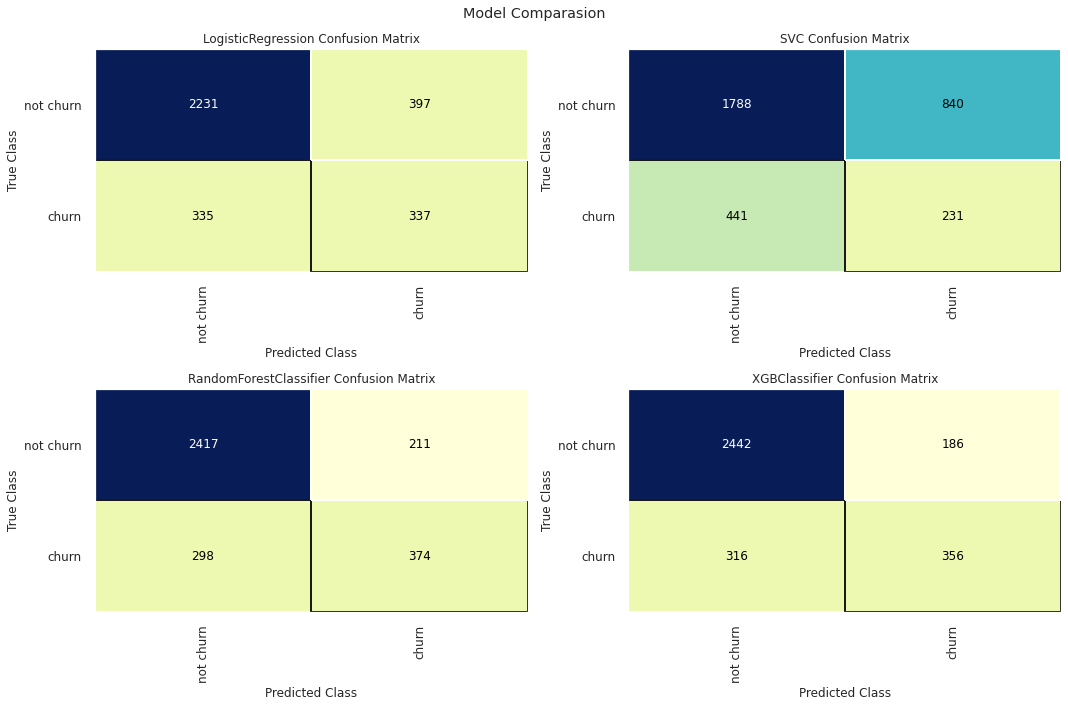

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

fig.suptitle('Model Comparasion')

cm_viz = ConfusionMatrix(lr,  classes=['not churn', 'churn'], support=True, cmap='YlGnBu', ax=axes[0][0])
cm_viz.fit(x_train_res, x_train_res)  
cm_viz.score(x_test, y_test)
cm_viz.finalize()

cm_viz = ConfusionMatrix(svm,  classes=['not churn', 'churn'], support=True, cmap='YlGnBu', ax=axes[0][1])
cm_viz.fit(x_train_res, x_train_res)  
cm_viz.score(x_test, y_test)
cm_viz.finalize()

cm_viz = ConfusionMatrix(rf,  classes=['not churn', 'churn'], support=True, cmap='YlGnBu', ax=axes[1][0])
cm_viz.fit(x_train_res, x_train_res)  
cm_viz.score(x_test, y_test)
cm_viz.finalize()

cm_viz = ConfusionMatrix(xgb,  classes=['not churn', 'churn'], support=True, cmap='YlGnBu', ax=axes[1][1])
cm_viz.fit(x_train_res, x_train_res)  
cm_viz.score(x_test, y_test)
cm_viz.finalize()



## 8.2. Lift curve

## 8.3. Acumulative curve